## Questions

- Is the energy and the power of the signal the same?! It's not because of the 1 / N constant
- why is the power interpreted as the variance of the signal?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.linalg as sl

%matplotlib inline
import matplotlib
import librosa as rosa
import sounddevice as sd

import os
import sys

sys.path.append("..")
from src import AudioSignal
from src import utils

## 2.1 Segmentation

In [2]:
female = AudioSignal(os.path.join(os.getcwd(), '../Exercise4', 'AudioFiles', 'female8khz.wav'))


/home/p0w3r/gitrepos/ssp20/notebooks/../Exercise4/AudioFiles/female8khz.wav
Successfully loaded audio signal with 1 channel(s) from file: /home/p0w3r/gitrepos/ssp20/notebooks/../Exercise4/AudioFiles/female8khz.wav


In [3]:
frame_centers_ms, frames = female.get_frames(frame_length_ms=32, frame_shift_ms=8)

## 2.2 Signal power

In [4]:
power = utils.compute_power_in_time_domain(frames)

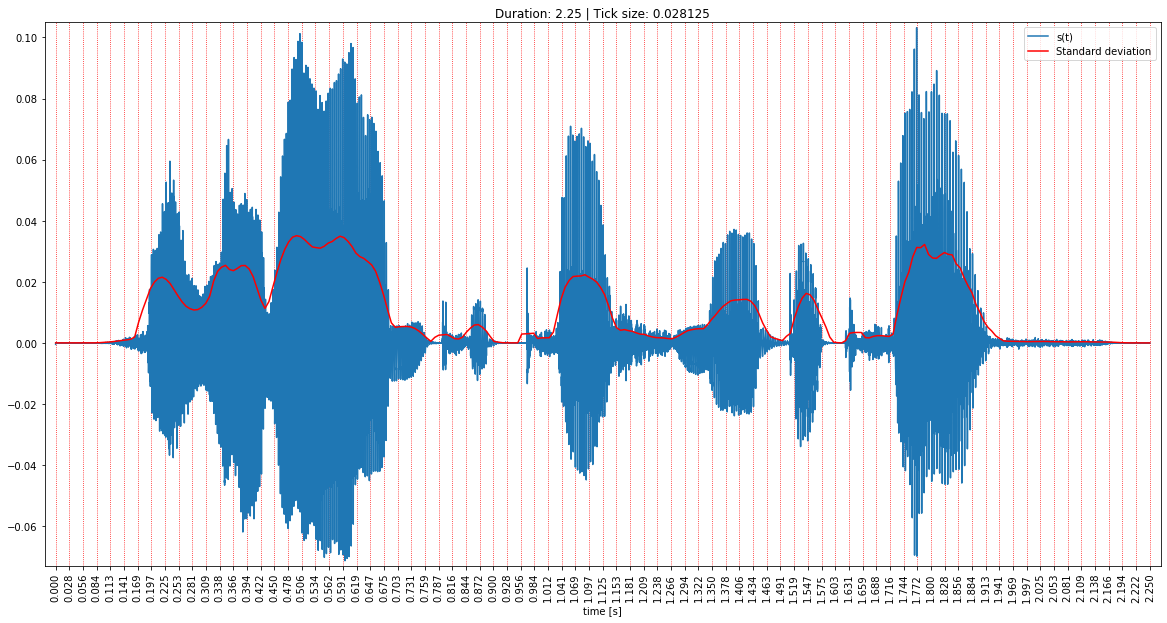

In [5]:
fig, axs = female.plot(return_plot=True)
t = np.linspace(0, female.duration_s, len(power))
axs.plot(t, np.sqrt(power), 'r', label='Standard deviation')
axs.legend()

## 2.3 Voiced / unvoiced decision

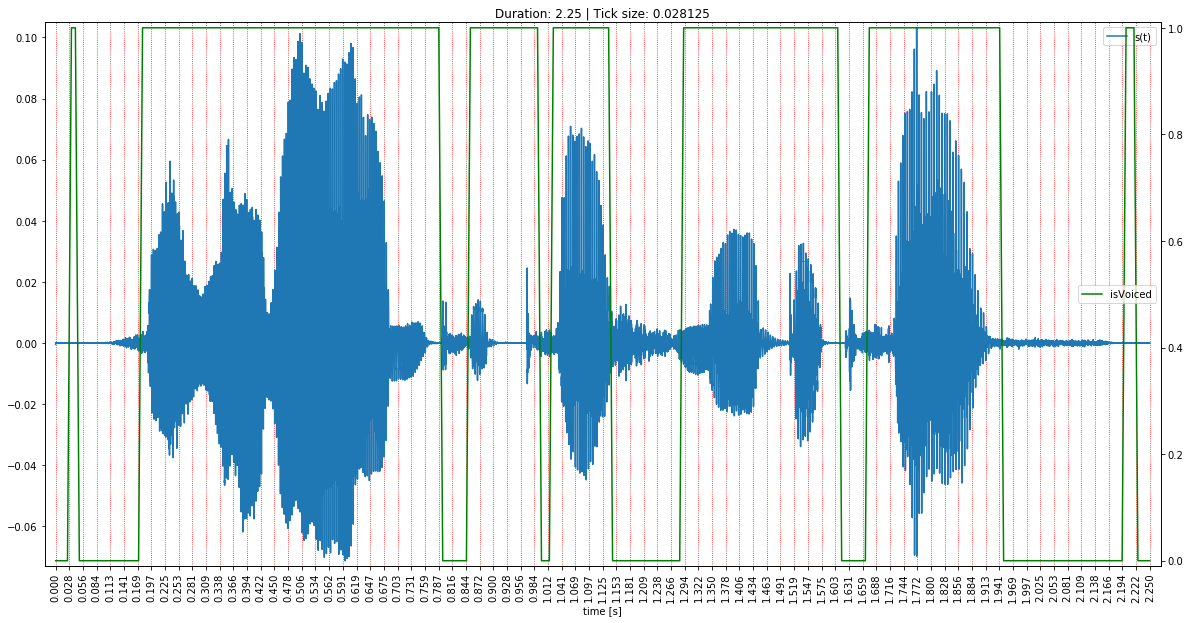

In [6]:
fig, axs = female.plot(return_plot=True)

is_voiced = utils.is_voiced(frames, threshold=.295)
t = np.linspace(0, female.duration_s, len(is_voiced))

axs2 = axs.twinx()
axs2.margins(x=0.01, y=0.01)
axs2.plot(t, is_voiced, 'g', label='isVoiced')
axs2.legend()

## 2.4 Fundamental frequency estimation

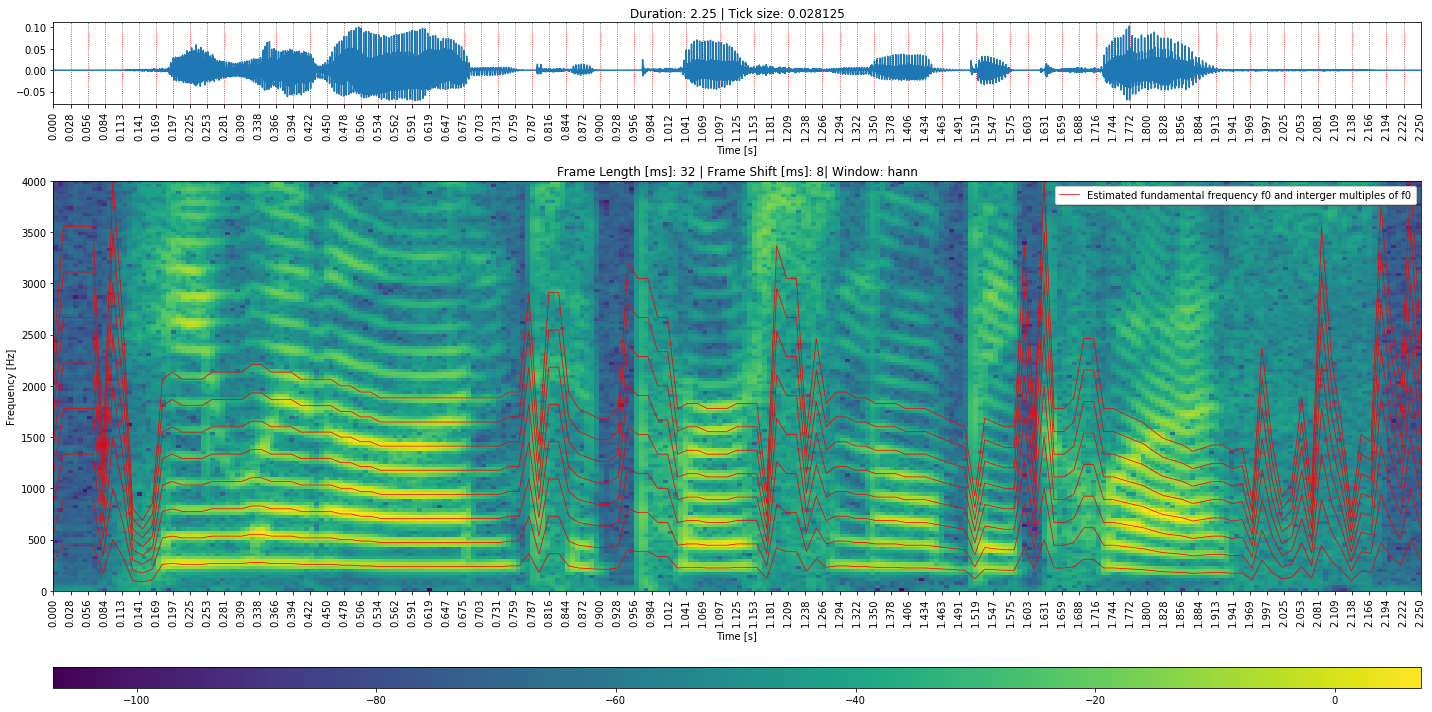

In [7]:
frame_length_ms=32
frame_shift_ms=8
stft, freq_axis, frame_centers_ms = female.compute_stft(frame_length_ms, frame_shift_ms)
fig, axs = female.plot_stft(stft, freq_axis, frame_centers_ms, frame_length_ms, frame_shift_ms, return_plot=True)


f0 = female.estimate_fundamental_freq()
t = np.linspace(0, female.duration_s, len(f0))
eff_plot = axs[1].plot(t, f0, color='r', linewidth=.75)
axs[1].legend((eff_plot), (['Estimated fundamental frequency f0 and interger multiples of f0']) , loc='upper right', shadow=True)
for i in range(2, 9):
    axs[1].plot(t, f0 * i, color='r', linewidth=.75)

## 2.5 Linear prediction coefficients / linear predictive coding

In [8]:
lpcs = utils.compute_lpc(frames, m=10)

## 3.1 LPCs and constant excitation signal

In [9]:
ex_voiced = utils.create_excitation_signal(female.duration_s * 1000, f0_hz=100, fs_hz=8000, voiced=True)
ex_unvoiced = utils.create_excitation_signal(female.duration_s * 1000, voiced=False)
assert len(ex_voiced.data) == len(ex_unvoiced.data)

Successfully loaded audio signal with 1 channel!
Successfully loaded audio signal with 1 channel!


278 278 278
Successfully loaded audio signal with 1 channel!


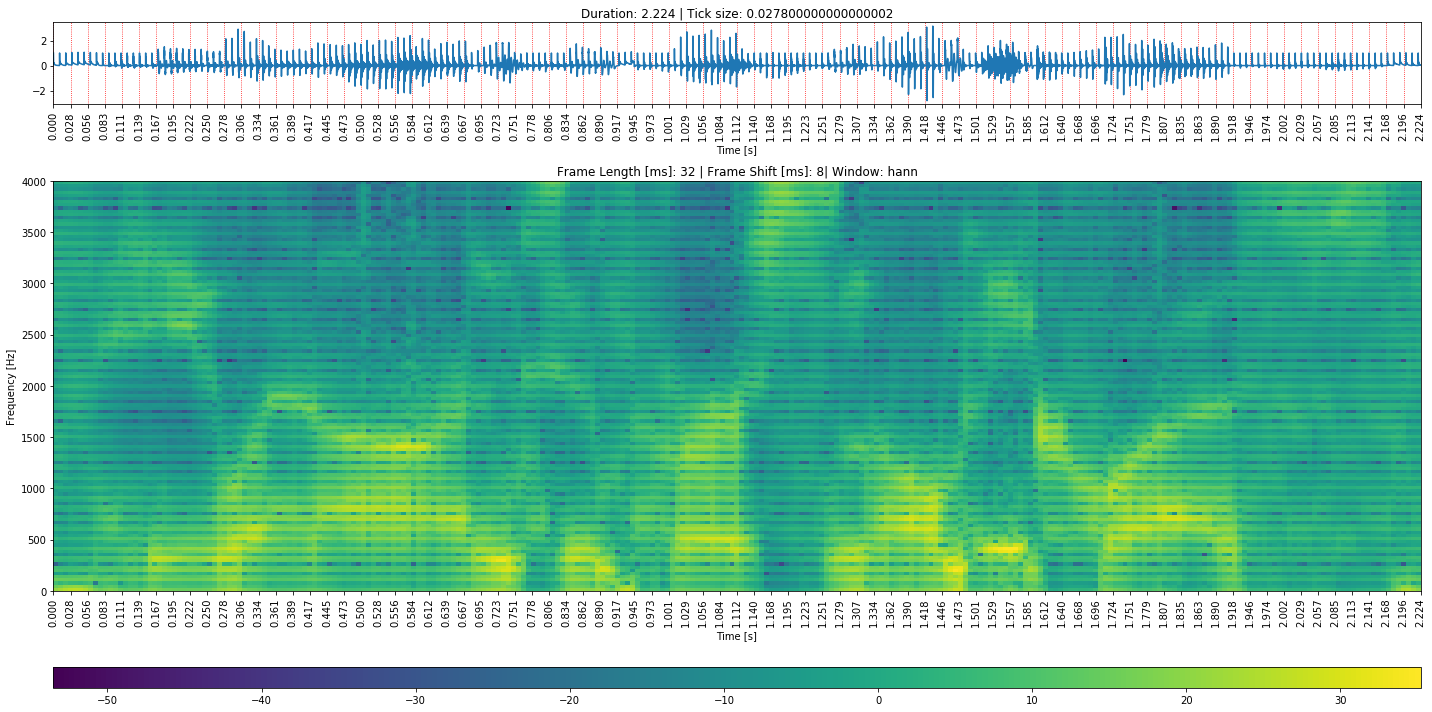

In [10]:
frame_centers_ms, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]
print(len(lpcs), len(ex_voiced_frames), len(frames))
filter_state_out = None
output = np.array([])
for frame, lpc in zip(ex_voiced_frames, lpcs):
    signal_out, filter_state_out = utils.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
# output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)

278 278 278
Successfully loaded audio signal with 1 channel!


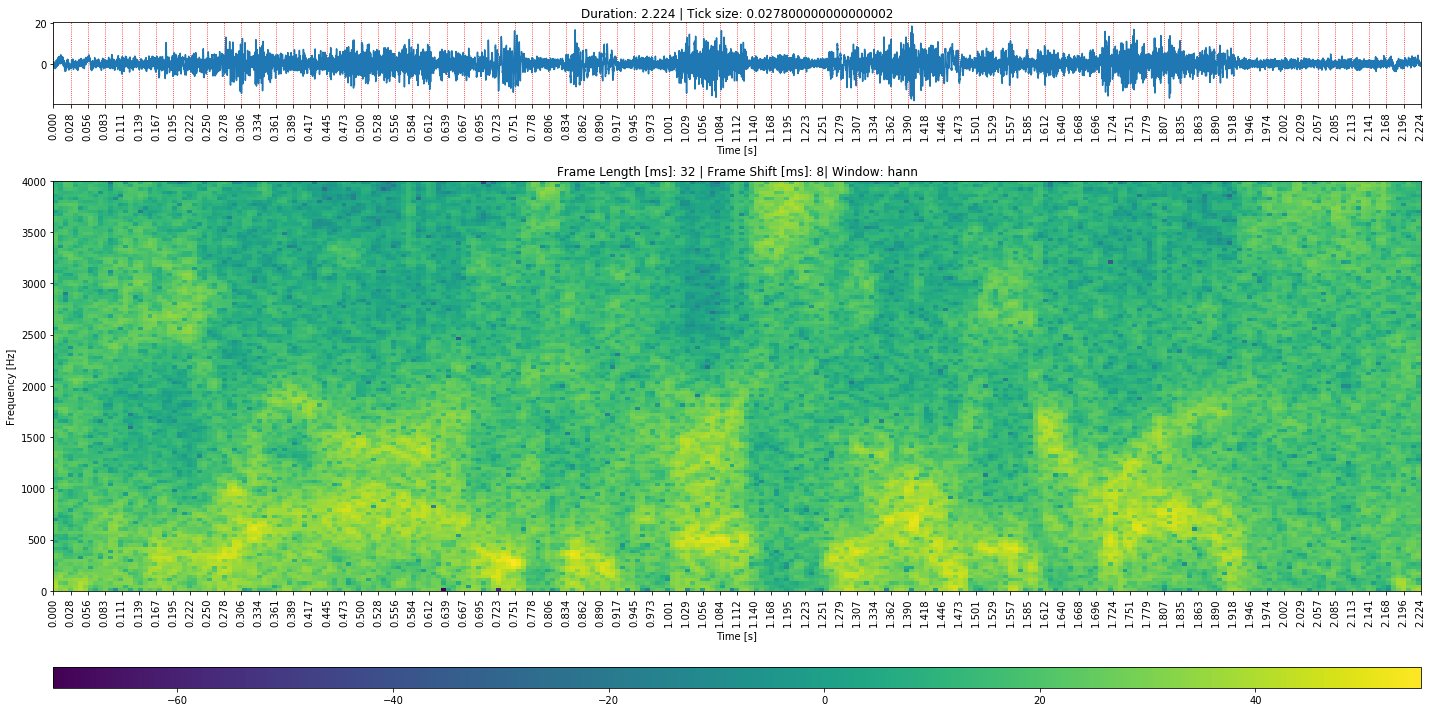

In [11]:
frame_centers_ms, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]
print(len(lpcs), len(ex_unvoiced_frames), len(frames))
filter_state_out = None
output = np.array([])
for frame, lpc in zip(ex_unvoiced_frames, lpcs):
    signal_out, filter_state_out = utils.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
# output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)

## 3.2 Voiced/unvoiced excitation

Successfully loaded audio signal with 1 channel!


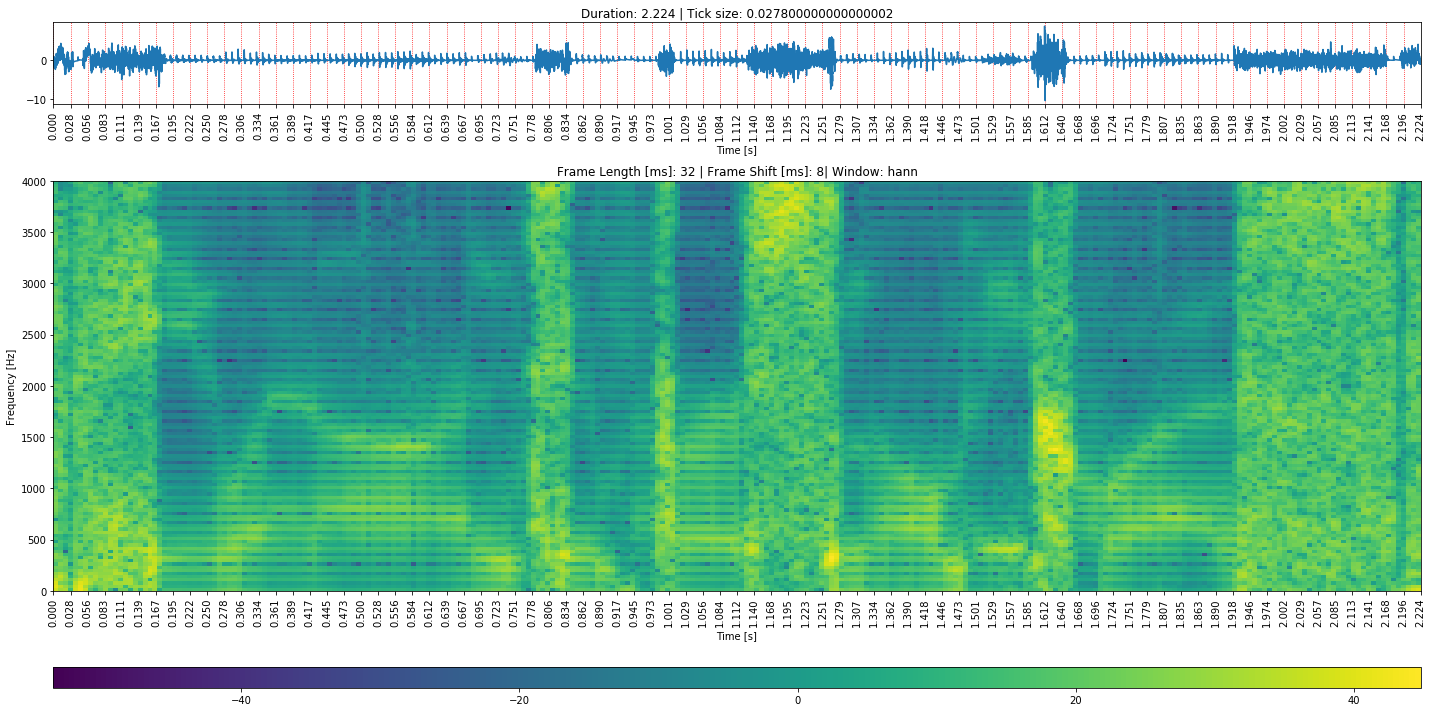

In [12]:
filter_state_out = None
output = np.array([])

_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]

_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]

for voiced_frame, unvoiced_frame, lpc, voiced in zip(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced):
    frame = voiced_frame
    if voiced == 0:
        frame = unvoiced_frame
    signal_out, filter_state_out = utils.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
# output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)

## 3.3 Amplitude modulation

Successfully loaded audio signal with 1 channel!


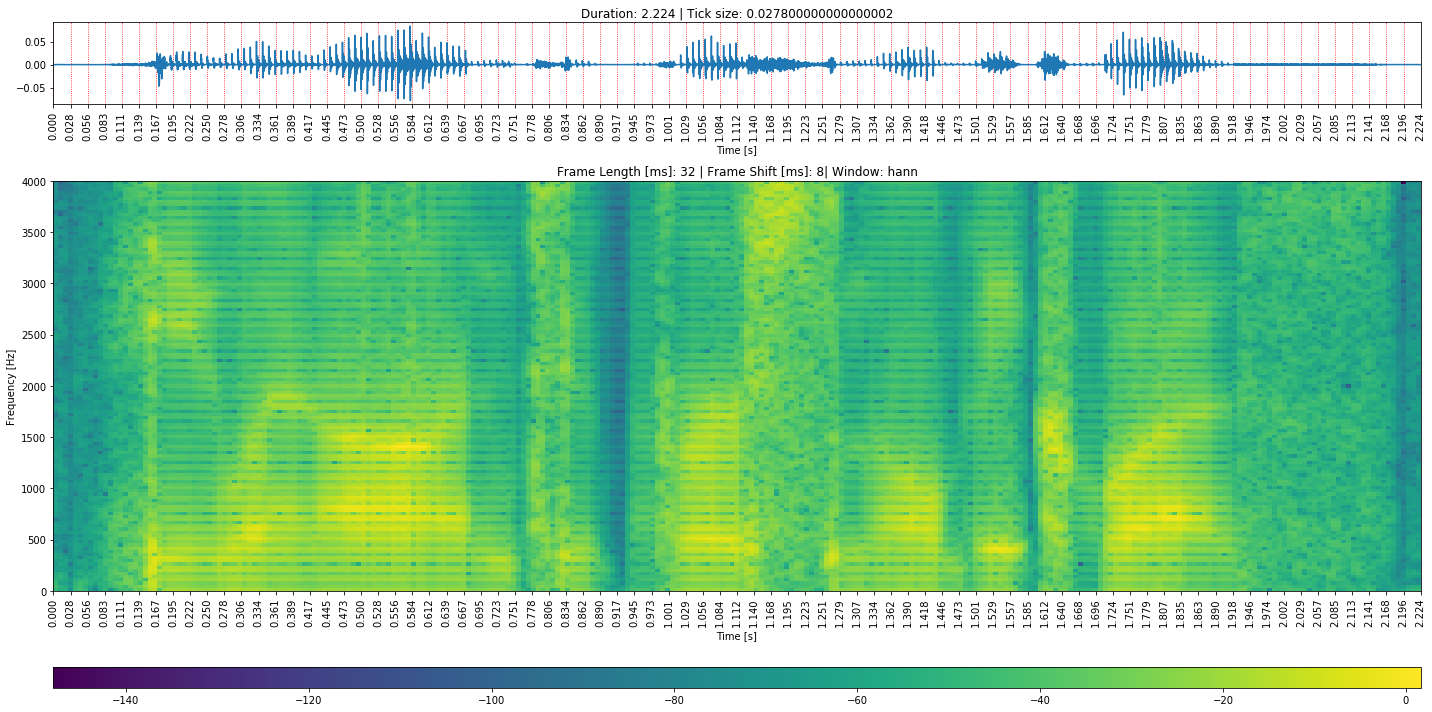

In [13]:
filter_state_out = None
output = np.array([])
_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames[:-3]

_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames[:-3]
for voiced_frame, unvoiced_frame, lpc, voiced, p in zip(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, power):
    # voiced unvoiced decision
    frame = voiced_frame
    if voiced == 0:
        frame = unvoiced_frame
        
    # create synthesized signal by convolving the excitation signal with the vocal tract filter (from the lpcs) 
    signal_out, filter_state_out = utils.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    
    # account for amplitude mod / gain
    signal_out = np.sqrt(p) * signal_out
    
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
# output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)

## 3.4 Variable f0

Successfully loaded audio signal with 1 channel!


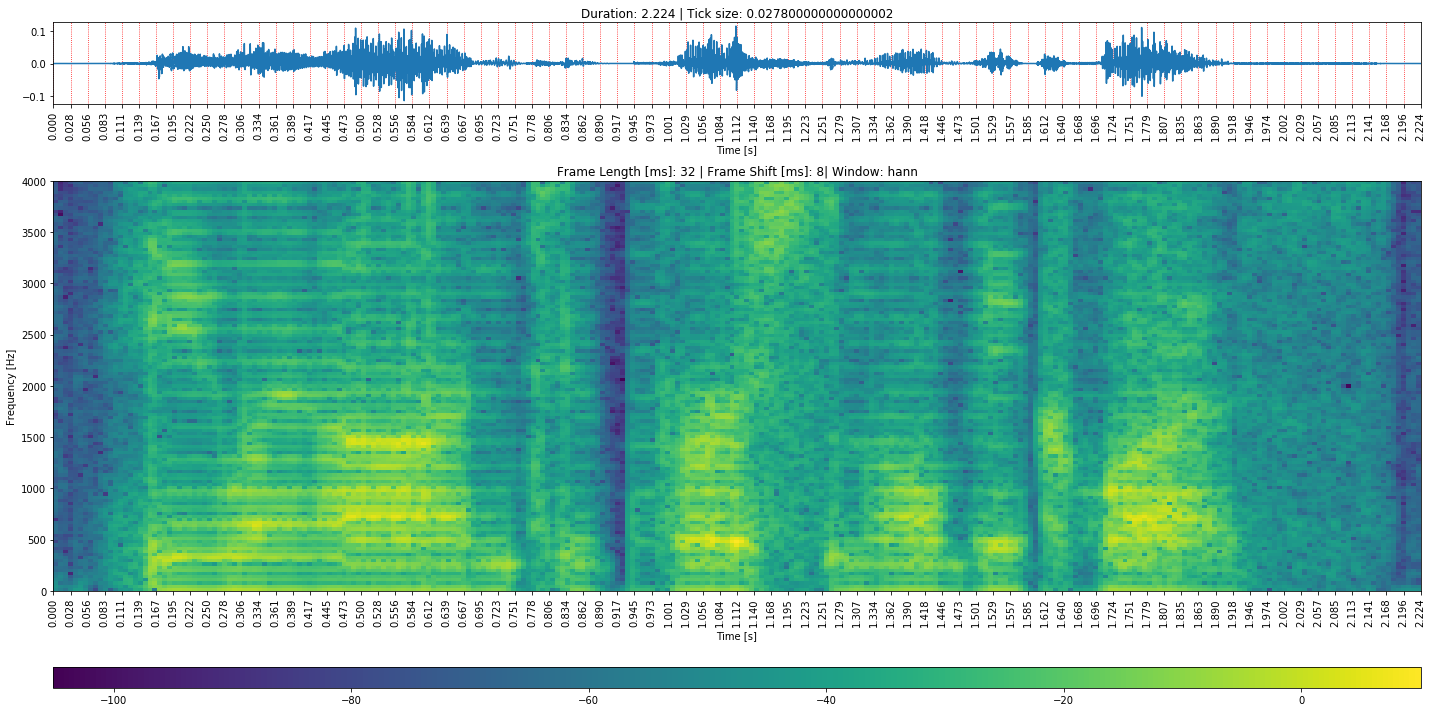

In [14]:
filter_state_out = None
output = np.array([])
# Create a counter ... 
f0_cnt = 0

_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames
_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames

fund_freq = female.estimate_fundamental_freq(frame_length_ms=8, frame_shift_ms=8)

for voiced_frame, unvoiced_frame, lpc, voiced, p, f0 in zip(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, power, fund_freq):
    # voiced unvoiced decision
    frame = unvoiced_frame
    if voiced == 1:
        frame = voiced_frame
        # variable f0
        for i in range(len(voiced_frame)):
            # ... that you increase for every sample of a voiced segment.
            f0_cnt += 1
            # Test if the counter is larger than the current fundamental period in samples.
            if f0_cnt > utils.hz_to_idx(f0, female.sampling_freq):
                # Every time this is the case, set the counter to zero ...
                f0_cnt = 0
                # ... and insert a pulse into the excitation signal at the
                # corresponding sample of the segment.
                frame[i] = 1
                
    # create synthesized signal by convolving the excitation signal with the vocal tract filter (from the lpcs) 
    signal_out, filter_state_out = utils.filter_adaptively(np.array([1]), np.concatenate(([1], lpc)), frame, filter_state_out)
    
    # account for amplitude mod / gain
    signal_out = np.sqrt(p) * signal_out
    
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
# output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)

## 3.5 No LPC

Successfully loaded audio signal with 1 channel!


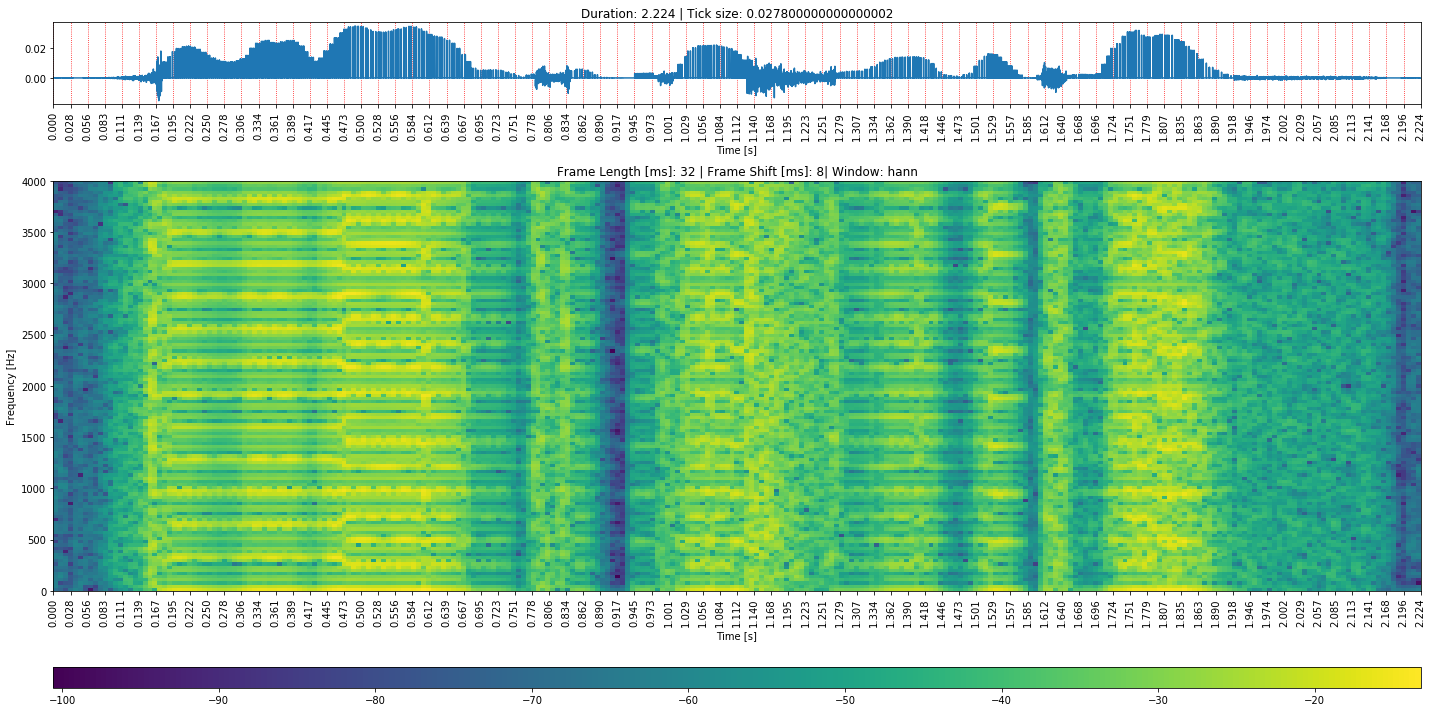

In [15]:
filter_state_out = None
output = np.array([])
# Create a counter ... 
f0_cnt = 0

_, ex_voiced_frames = ex_voiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_voiced_frames = ex_voiced_frames
_, ex_unvoiced_frames = ex_unvoiced.get_frames(frame_length_ms=8, frame_shift_ms=8)
ex_unvoiced_frames = ex_unvoiced_frames

fund_freq = female.estimate_fundamental_freq(frame_length_ms=8, frame_shift_ms=8)

for voiced_frame, unvoiced_frame, lpc, voiced, p, f0 in zip(ex_voiced_frames, ex_unvoiced_frames, lpcs, is_voiced, power, fund_freq):
    # voiced unvoiced decision
    frame = unvoiced_frame
    if voiced == 1:
        frame = voiced_frame
        # variable f0
        for i in range(len(voiced_frame)):
            # ... that you increase for every sample of a voiced segment.
            f0_cnt += 1
            # Test if the counter is larger than the current fundamental period in samples.
            if f0_cnt > utils.hz_to_idx(f0, female.sampling_freq):
                # Every time this is the case, set the counter to zero ...
                f0_cnt = 0
                # ... and insert a pulse into the excitation signal at the
                # corresponding sample of the segment.
                frame[i] = 1
                
    # create synthesized signal by convolving the excitation signal with the vocal tract filter (from the lpcs) 
    signal_out, filter_state_out = utils.filter_adaptively(np.array([1]), np.array([1]), frame, filter_state_out)
    
    # account for amplitude mod / gain
    signal_out = np.sqrt(p) * signal_out
    
    output = np.append(output, signal_out)

output_sig = AudioSignal(data=output, sampling_freq_hz=8000)
# output_sig.play()
output_sig.plot_stft(frame_length_ms=32, frame_shift_ms=8)

## 4 Quantization

### 4.1 Implementation of a uniform scalar quantizer


In [16]:
def quantize_encoder(x: np.ndarray, num_bits: int, x_range: float, x_center: float) -> np.ndarray:
    dx = x_range / (2 ** num_bits)
    x_min, x_max = x_center - ( x_range / 2), x_center + ( x_range / 2)
    
    quant_idxs = np.floor(x / dx)
    
    return quant_idxs

def quantize_decoder(quant_idxs: np.ndarray, num_bits: int, x_range: float, x_center: float) -> np.ndarray:
    dx = x_range / (2 ** num_bits)
    x_min, x_max = x_center - ( x_range / 2), x_center + ( x_range / 2)
    
    quantized_x = (quant_idxs * dx) + dx / 2
    clipped = np.clip(quantized_x, x_min, x_max)
    
    return clipped
    

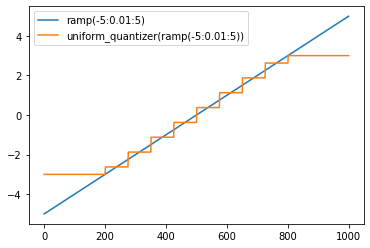

In [17]:
ramp = np.arange(-5, 5, 0.01)

num_bits = 3
x_range = 6
x_center = 0
plt.plot(ramp, label='ramp(-5:0.01:5)')
qidx = quantize_encoder(ramp, num_bits, x_range, x_center)
qs = quantize_decoder(qidx, num_bits, x_range, x_center)
plt.plot(qs, label='uniform_quantizer(ramp(-5:0.01:5))')
plt.legend()

### 4.2 Quantizing the fundamental frequency

x_range 320
x_center 240.0


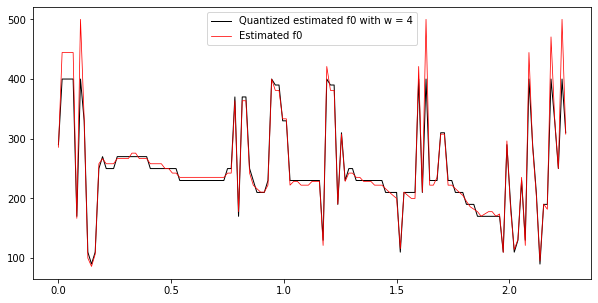

In [18]:
def quantize_f0(num_bits=4):
    f_min, f_max = 80, 400
    x_range = f_max - f_min
    x_center = f_min + (x_range / 2)

    print('x_range %s' %  x_range)
    print('x_center %s' %  x_center)

    # estimate f0
    f0 = female.estimate_fundamental_freq()
    t = np.linspace(0, female.duration_s, len(f0))

    # quantize 
    qidx = quantize_encoder(f0, num_bits, x_range, x_center)
    qs = quantize_decoder(qidx, num_bits, x_range, x_center)
    
    return qs, f0

w = 4
qs, f0 = quantize_f0(w)

plt.figure(figsize=(10,5))
eff_plot_q = plt.plot(t, qs, color='k', linewidth=1., label='Quantized estimated f0 with w = %s' % w)
eff_plot = plt.plot(t, f0, color='r', linewidth=.75, label='Estimated f0')
plt.legend()

x_range 320
x_center 240.0
x_range 320
x_center 240.0


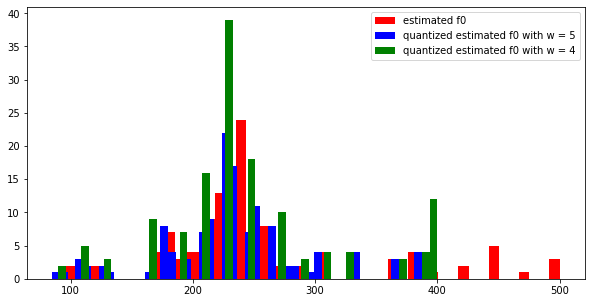

In [19]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.hist(f0, bins=50, color='r', label='estimated f0');

w = 5
qs, f0 = quantize_f0(w)
ax.hist(qs, bins=50, color='b', label='quantized estimated f0 with w = %s' % w);

w = 4
qs, f0 = quantize_f0(w)
ax.hist(qs, bins=50, color='g', label='quantized estimated f0 with w = %s' % w);
ax.legend()

### 4.3 Quantizing the signal energy

In [20]:
def quantize(x, num_bits, x_range, x_center):
    
    qidx = quantize_encoder(x, num_bits, x_range, x_center)
    qs = quantize_decoder(qidx, num_bits, x_range, x_center)
    
    return qs

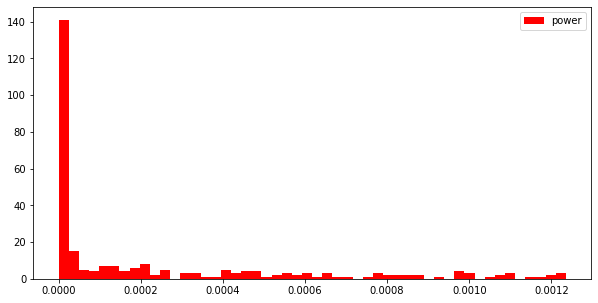

In [21]:
power = utils.compute_power_in_time_domain(frames)

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.hist(power, bins=50, color='r', label='power');

ax.legend()

0.31619653 5.066395e-07
x_range 0.31619602
x_center 0.1580980122089386


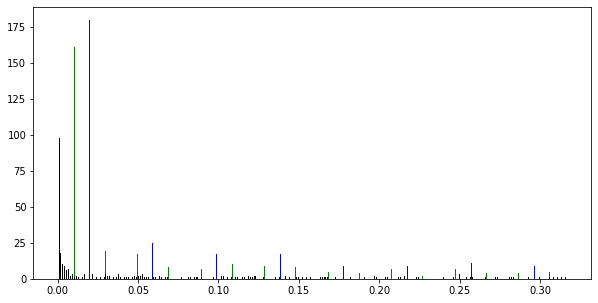

In [22]:
energy = utils.compute_energy_in_time_domain(frames)

fig, ax = plt.subplots(1, figsize=(10, 5))
num_bits = 3
x_range = np.max(energy) - np.min(energy)
x_center = x_range / 2

print(np.max(energy), np.min(energy))
print("x_range %s" % x_range)
print("x_center %s" % x_center)

num_bits = 3
qs = quantize(energy, num_bits, x_range, x_center)
ax.hist(qs, bins=500, color='b', label='quantized power with w = %s' % num_bits);

num_bits = 4
qs = quantize(energy, num_bits, x_range, x_center)
ax.hist(qs, bins=500, color='g', label='quantized power with w = %s' % num_bits);

num_bits = 8
qs = quantize(energy, num_bits, x_range, x_center)
ax.hist(qs, bins=500, color='k', label='quantized power with w = %s' % num_bits);

#### Now, take the logarithm of the energy values. Plot a histogram and find x_range as well as x_center.


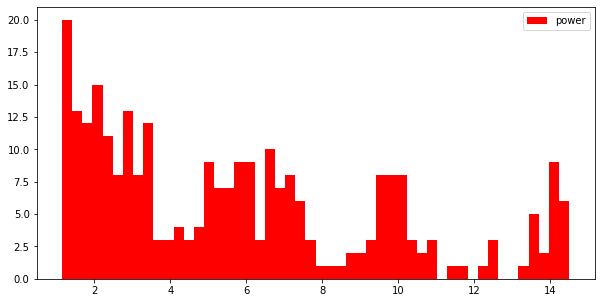

In [23]:
energy = -np.log(utils.compute_energy_in_time_domain(frames))
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.hist(energy, bins=50, color='r', label='power');

ax.legend()

14.495466 1.1513913
x_range 13.344075
x_center 6.672037601470947


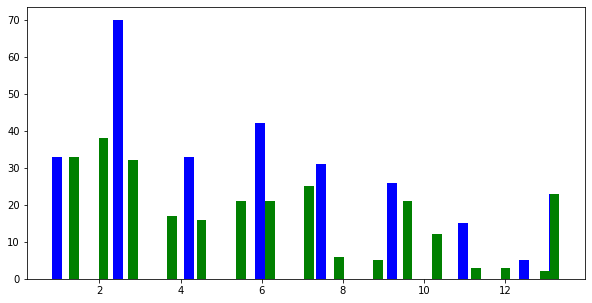

In [24]:
fig, ax = plt.subplots(1, figsize=(10, 5))
num_bits = 3
x_range = np.max(energy) - np.min(energy)
x_center = x_range / 2

print(np.max(energy), np.min(energy))
print("x_range %s" % x_range)
print("x_center %s" % x_center)


num_bits = 3
qs = quantize(energy, num_bits, x_range, x_center)
ax.hist(qs, bins=50, color='b', label='quantized log energy with w = %s' % num_bits);

num_bits = 4
qs = quantize(energy, num_bits, x_range, x_center)
ax.hist(qs, bins=50, color='g', label='quantized log energy with w = %s' % num_bits);

## 4.4 Quantizing the LPCs